# Lesson/Article 01 - Face detector

**Author: Gabriel Moretti de Souza - 200018205**

**Author's GitHub username: MorettiGS**

## Objective

In this article, we are going through the creation and usage of a **classifier** using Artificial Intelligence, with the main purpose of training it to determine whether or not there is a human face on a given image.

For the creation of said classifier, there will be the use of DuckDuckGo to search for the images used on the dataset, and the fast.ai framework for the neural network in charge of recognition and classification.

This search and results could be useful, in a real life situation, when treating to security, especially on camera footage and/or images that could contain decisive information on a suspect or fugitive.

## Pre-requisites

Before going any further, it is essential that we get the necessary dependencies for the AI training: DuckDuckGo and fastai. If you do not have them installed, you can do it with the following commands:


In [3]:
# -U is used for updating the library before the install
# -qq is used for a silent install
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

## Data

Now we can work on the data that will be used on this AI training. As said before, the data will be obtained by the use of the DuckDuckGo search, as follows:

In [10]:
# Importing all the necessary dependencies
from duckduckgo_search import ddg_images
from fastcore.all import *

# For simplification, we can create a function with two parameters:
# - Type of image being searched
# - Amount of images being searched

def search_images(term, max_images=300):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Now, it is possible to use the function above to search for images with people's faces in it, aswell as images without.

For this search, we can use the function **download_url()**, from the *fastdownload* library, making it easier to download found images for further visualization and inspection.

Said code for the search follows:

In [21]:
# Importing all the necessary dependencies
from fastdownload import download_url
from fastai.vision.all import *

# Usage of "search_images" to search for people's faces
# As images without human faces, we will be searching for human bodies, without faces
face = search_images('face', max_images=1)[0]
body = search_images('Body', max_images=1)[0]

# We will be using the "show_progress" attribute for better download
#  progress visualization.
download_url(face, 'face.jpg', show_progress=True)
download_url(body, 'body.jpg', show_progress=True)

Path('body.jpg')

After downloading an example for each case, we can discern whether or not they will be a satisfactory example for our AI training. By using the Image.open() function, we can access the path for the image and visualize it:

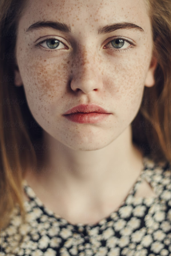

In [22]:
Image.open('face.jpg').to_thumb(256, 256)

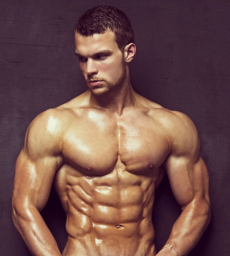

In [23]:
Image.open('body.jpg').to_thumb(256, 256)

As the results were satisfactory, by finding a clear image with a human face on the first search, and without on the second one, we will be progressing to obtain the dataset.

## Dataset

With the use of the previous functions, it is possible to download the dataset that is going to be used. For this, we also need to use a new function **sleep()**, from the **time** library, to prevent data overload.

In [24]:
# Importing the "sleep" function
from time import sleep

# Creating variables for dataset search
searchs = 'face', 'body'
path = Path('face_or_not')

# Searching for some possible cases
for search in searchs:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{search}'))
    sleep(10)
    download_images(dest, urls=search_images(f'beautiful {search}'))
    sleep(10)
    download_images(dest, urls=search_images(f'flat {search}'))
    sleep(10)
    download_images(dest, urls=search_images(f'big {search}'))
    sleep(10)
    download_images(dest, urls=search_images(f'round {search}'))
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

/home/gabriel/.venv/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Before going further into the training, we need to be sure we have removed all unusable and/or corrupted images. We can do that with the following code:

In [27]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Training the AI model

With the dataset ready, we can now begin to train our model. For that, we'll need an object that contains the data used to train models: **Dataloaders**, or, in the fastai library, a **DataBlock**.

The process for the creation of that DataBlock is described in the next code cell, as well as the explanation for each of its parameters:

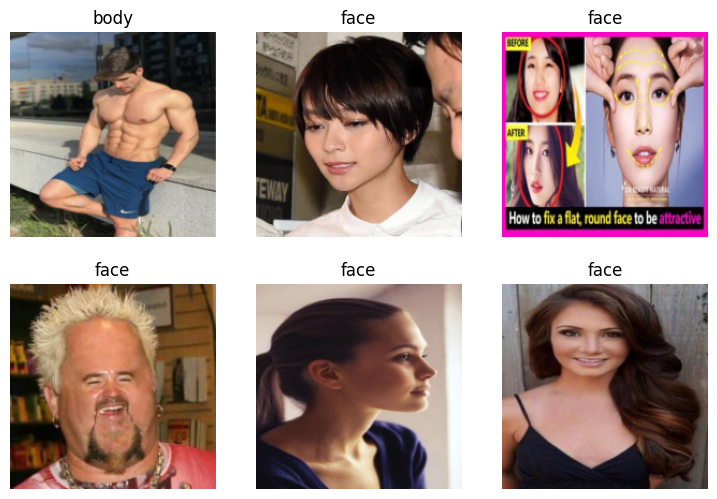

In [28]:
# Creation of the DataBlock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

# - blocks: Indicates, as a minimum of two parameters, the input for the images as
#  ImageBlock and the image categorization in CategoryBlock
# - get_items: Fetches image data
# - splitter: Defines the division between training data and validation data
#  inside the dataset. In this case: 20% for validation.
# - get_y: Used to separate the categorizing block based on the parent folder.
# - item_tfms: Resize method for out-of-consistency input sizes on dataset images.

# Shows 6 images as an example of the dataset.
dls.show_batch(max_n=6)

Now we can actually use our dataset to begin training our model.

The best function to use for this training is the **vision_learner**, as it uses the fastest and most utilized model **resnet18**. Along with it, the fastai function **fine_tune** will help adjusting a pre-training model using the best practices available.

The training process can be resumed to the following lines of code:

In [63]:
# Utilizing 'vision_learner' for the preparation of the training model
learn = vision_learner(dls, resnet18, metrics=error_rate)

# Training the model, where the function parameter indicates the number of epochs used
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.689712,0.309963,0.091463,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.198040,0.214192,0.067073,00:23
1,0.122542,0.225560,0.073171,00:23
2,0.086940,0.221446,0.060976,00:22
3,0.065340,0.208123,0.054878,00:23
4,0.047219,0.202206,0.048780,00:22
5,0.037678,0.197681,0.048780,00:23


## Validating

With the model now trained, we can now validate its results, using the method **predict** for each case, this way predicting if the images are being categorized correctly:

It has a face.
Probability: 0.9998


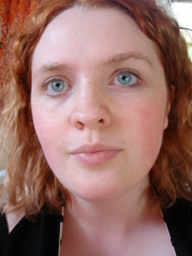

In [99]:
# Test case for a face
download_url(search_images('face', max_images=10)[4], 'face.jpg', show_progress=False)
is_face,_,probability = learn.predict(PILImage.create('face.jpg'))
print(f"It has a {is_face}.")
print(f"Probability: {probability[1]:.4f}")
Image.open('face.jpg').to_thumb(256,256)

It is a body.
Probability: 1.0000


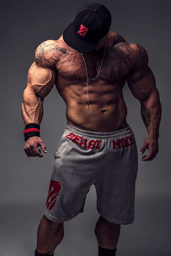

In [133]:
# Test case for a body
download_url(search_images('body', max_images=10)[3], 'body.jpg', show_progress=False)
is_body,_,probability = learn.predict(PILImage.create('body.jpg'))
print(f"It is a {is_body}.")
print(f"Probability: {probability[0]:.4f}")
Image.open('body.jpg').to_thumb(256,256)

## Conclusion

As we could see, the model trained outputted the correct results.

On the other hand, it is possible the continue training the model in order to achieve better results on the probability of success, strengthening the model's capability.